# Tsodyks-Markram model of short-term synaptic plasticity

CHOOSE FORMULATION THAT MAKES SENSE WITH CODE (discretised like in Mike's paper?)

In this notebook we demonstrate how to simulate the Tsodyks-Markram model:


\begin{equation}
\frac{dR(t)}{dt} = \frac{1-R(t)-E(t)}{D} - U(t)R(t)\delta(t-t_{spike}) \\
\end{equation}


\begin{equation}
\frac{dU(t)}{dt} = \frac{U_{0}-U(t)}{F} + U_{0}*(1-U(t))\delta(t-t_{spike}) \\
\end{equation}


\begin{equation}
\tau_{mem} \frac{dV(t)}{dt} = -V + R_{inp}I_{syn}(t)
\end{equation}


where $I_{syn}(t)=R(t)U(t)*W$

# Simulation

Description and explanation?

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets


In [2]:
def iaf_stp(times, spike_times, U, t_fac, t_rec, I_in,
            tau=5, spike_amp=4):
    """
    
    Parameters
    ----------
    
    t
        time vector in ms
        
    spike_times
        in ms
        
    u
        Utilization constant (how much is released)
        
    tfac
        Time constant of fac
    
    trec
        Time constant of inh
        
    
    """
    
    assert len(times) == len(I_in)
    
    tau = 5
    spike_amp = 4
    W = 1.0     #postsynatpic weight
    
    R = 1
    u=U
    uP = U
    RP = 1
    last_spike = -9e10
    v=0
    
    
    V = np.zeros(len(times))
    Vout = np.zeros(len(times))
    release = np.zeros((len(times), 4))
    
    release[0, 1:] = [R * U, U, R]
    
    for t in times:
        
        spike = t in spike_times        
        ipi = t - last_spike
                
        e_rec = np.exp(-ipi / t_rec)
        e_fac = np.exp(-ipi / t_fac)
        
        RP = R * (1 - u) * e_rec + 1 - e_rec
        uP = u * e_fac + U * (1 - u * e_fac)        

        release[t] = [0, RP * uP , uP, RP]
        
        if spike:
            R = R * (1 - u) * e_rec + 1 - e_rec
            u = u * e_fac + U * (1 - u * e_fac)
            release[t, 0] = R * u * W
            uP = u
            RP = R
            
            last_spike = t
            
        if Vout[t-1] == spike_amp:
            V[t] = 0
            Vout[t] = V[t] 
        else:
            V[t] = v - v/tau + release[t, 0] + I_in[t]
            Vout[t] = V[t]
            if V[t] > 1:
                Vout[t] = spike_amp
            v = V[t]


            
    return Vout, release


interactive(children=(FloatSlider(value=0.5, description='U', max=1.0, step=0.01), IntSlider(value=200, descri…

<function __main__.update(U=0.5, tFac=200, tRec=20)>

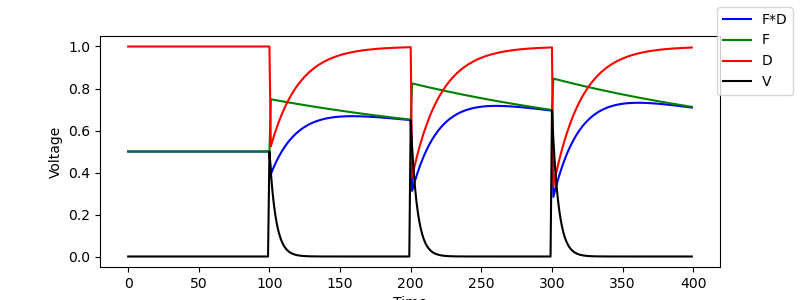

In [3]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)

ax.set_xlabel("Time")
ax.set_ylabel("Voltage")

def update(U=.5,tFac=200, tRec=20):
    Iin = np.zeros(400)

    Vout, p = iaf_stp(
        times=np.arange(400), 
        #spike_times=np.arange(100, 1000, 100), 
        spike_times=[100, 200, 300],
        U=U, 
        t_fac=tFac, 
        t_rec=tRec, 
        I_in=Iin)
    
    for l in ax.lines:
        l.remove()
    

    #ax.plot(p[:, 0], c='black', label="0")
    ax.plot(p[:, 1], c='blue', label="F*D")
    ax.plot(p[:, 2], c='green', label="F")
    ax.plot(p[:, 3], c='red', label="D")
    ax.plot(Vout, c='black', label="V")

    fig.legend()
widgets.interact(update, U=(0, 1, .01), tFac=(0, 500, 10), tRec=(0, 200, 5))

# Exersice

Can you create an “interval selective” synapse whose 2nd post synaptic potential (PSP) amplitude is higher for a 100 ms interval compared to 50 and 200 ms? 